# PTPN11
PTPN11 encodes SHP-2, a protein tyrosine phosphatase involved in intracellular signaling pathways that regulate cell growth, differentiation, and survival. It plays a key role in the RAS/MAPK signaling pathway, which is crucial for normal development and oncogenesis. Mutations in this gene are involved in several diseases, including Noonan syndrome and juvenile leukemia.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


# PTPN11
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for PTPN11.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'PTPN11'
mane_tx_id = 'NM_002834.5'
mane_protein_id = 'NP_002825.3' 

pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_name = 'PTPN11'
phenopacket_store_release = '0.1.24'

registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
del phenopackets
validation.summarize()

Individuals Processed: 100%|██████████| 70/70 [00:00<00:00, 1168.03 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo)
viewer.process(cohort=cohort,transcript_id=mane_tx_id)

n,HPO Term
37,Hypertelorism
29,Multiple lentigines
26,Short stature
18,Pulmonic stenosis
18,Low-set ears
15,Ptosis
15,Webbed neck
13,Global developmental delay
12,Multiple enchondromatosis
12,Multiple exostoses


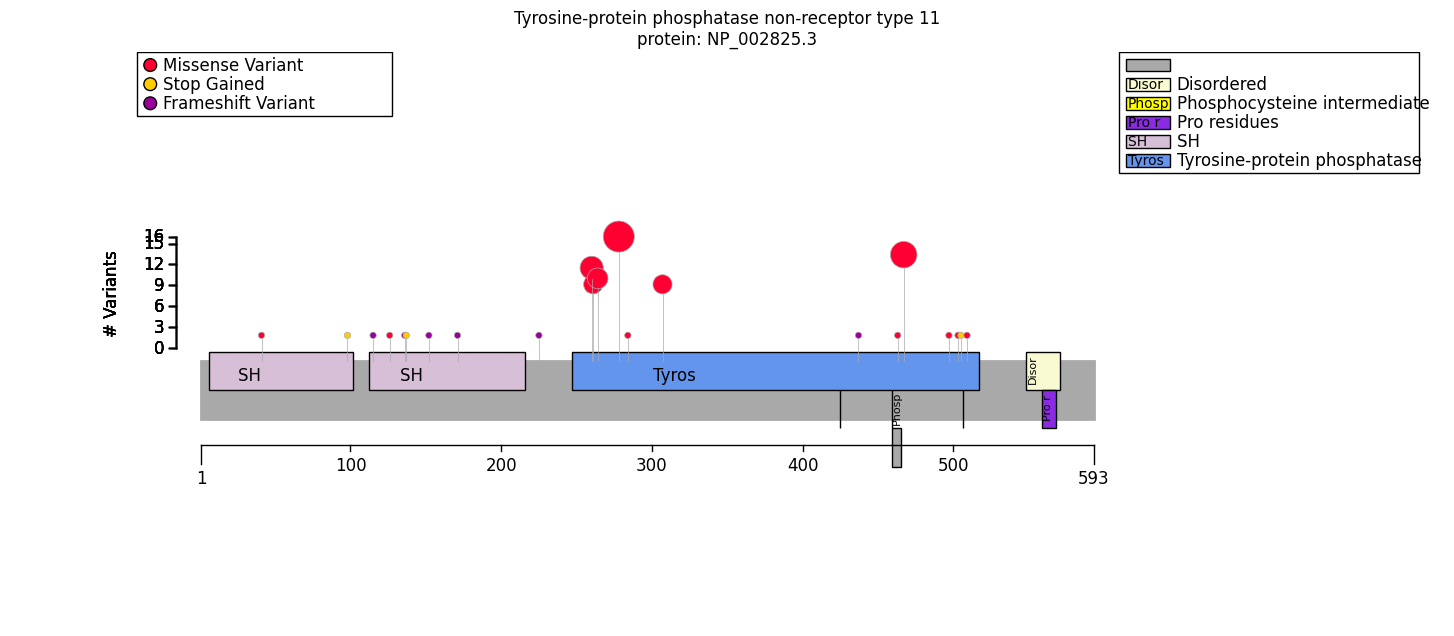

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

ptpn11_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
ptpn11_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer

viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
2,SH2 1,Domain,7 - 102,p.Thr42Ala; p.Lys99Ter
6,SH2 2,Domain,113 - 216,p.Arg138Ter; p.Ser118TrpfsTer10; p.Thr153LysfsTer8; p.Val137ArgfsTer17; p.Thr127Ile; p.Ile172GlyfsTer13
58,Tyrosine-protein phosphatase,Domain,248 - 517,p.Leu261Phe; p.Gln510Glu; p.Gly464Ala; p.Leu262Arg; p.Arg265Gln; p.Phe285Leu; p.Thr468Met; p.Gln506Ter; p.Leu261His; p.Leu439TrpfsTer33; p.Leu262Phe; p.Asn308Asp; p.Arg498Leu; p.Tyr279Cys; p.Met504Val
0,,Binding site,426 - 425,
0,Phosphocysteine intermediate,Active site,460 - 459,
1,,Binding site,460 - 465,p.Gly464Ala
0,,Binding site,507 - 506,
0,Disordered,Region,549 - 571,
0,Pro residues,Compositional bias,560 - 568,


# Genotype phenotype correlation analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import monoallelic_classifier

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_predicate = monoallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="Missense",
    b_label="Other"
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_predicate,
    pheno_clfs=pheno_clfs,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)

Reason,Count
Skipping term because one genotype had zero observations,10
"Skipping ""general"" level terms",80
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),186


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,Missense,Other,Corrected p values,p values
Hypertelorism [HP:0000316],37/41 (90%),0/12 (0%),2.728808e-08,6.822020e-09
Webbed neck [HP:0000465],15/20 (75%),0/12 (0%),5.884155e-05,2.942077e-05
Pulmonic stenosis [HP:0001642],18/34 (53%),0/12 (0%),1.640406e-03,1.230305e-03
"Intellectual disability, mild [HP:0001256]",8/23 (35%),0/12 (0%),3.156028e-02,3.156028e-02


In [10]:
from gpsea.analysis.predicate import variant_key

tyr279cys = variant_key("12_112473023_112473023_A_G") # c.836A>G	p.Tyr279Cys
tyr279cys_clf = missense_predicate = monoallelic_classifier(
    a_predicate=tyr279cys,
    b_predicate=~tyr279cys,
    a_label="Tyr279Cys",
    b_label="Other"
)
tyr279cys_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=tyr279cys_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=tyr279cys_result)

Allele group,Tyr279Cys,Other,Corrected p values,p values
Webbed neck [HP:0000465],0/5 (0%),15/27 (56%),0.275003,0.045641
Pulmonic stenosis [HP:0001642],1/9 (11%),17/37 (46%),0.275003,0.069125
Hypertelorism [HP:0000316],14/16 (88%),23/37 (62%),0.275003,0.103126
Short stature [HP:0004322],4/6 (67%),22/24 (92%),0.338259,0.169130
"Intellectual disability, mild [HP:0001256]",4/11 (36%),4/24 (17%),0.361168,0.225730
Multiple lentigines [HP:0001003],16/16 (100%),13/13 (100%),1.000000,1.000000
Hypermelanotic macule [HP:0001034],16/16 (100%),15/15 (100%),1.000000,1.000000
Abnormal location of ears [HP:0000357],8/8 (100%),20/20 (100%),1.000000,1.000000


In [11]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Hypertelorism [HP:0000316],20/21 (95%),17/22 (77%),1.0,0.185283
Pulmonic stenosis [HP:0001642],9/16 (56%),9/20 (45%),1.0,0.737986
Short stature [HP:0004322],11/13 (85%),15/17 (88%),1.0,1.000000
Multiple lentigines [HP:0001003],13/13 (100%),16/16 (100%),1.0,1.000000
Abnormal location of ears [HP:0000357],14/14 (100%),14/14 (100%),1.0,1.000000
Hypermelanotic macule [HP:0001034],14/14 (100%),17/17 (100%),1.0,1.000000


In [12]:
from gpsea.model.genome import Region
from gpsea.analysis.predicate import protein_region

tkd_n = protein_region(region=Region(247,400), tx_id=mane_tx_id)
tkd_c = protein_region(region=Region(401,517), tx_id=mane_tx_id)

tkd_clf = missense_predicate = monoallelic_classifier(
    a_predicate=tkd_n,
    b_predicate=tkd_c,
    a_label="TK domain N term",
    b_label="TK domain C term"
)
tkd_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=tkd_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=tkd_result)

Allele group,TK domain N term,TK domain C term,Corrected p values,p values
Pulmonic stenosis [HP:0001642],14/22 (64%),4/14 (29%),0.429011,0.085802
Hypertelorism [HP:0000316],24/26 (92%),12/16 (75%),0.449554,0.179822
Short stature [HP:0004322],20/22 (91%),5/6 (83%),0.883191,0.529915
Multiple lentigines [HP:0001003],16/16 (100%),13/13 (100%),1.000000,1.000000
Hypermelanotic macule [HP:0001034],17/17 (100%),14/14 (100%),1.000000,1.000000


# Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=tyr279cys_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=tkd_result
    ),
     GPAnalysisResultSummary.from_multi(
        result=mf_result
    )
)

caption = "No previous statistical analysis of correlations with PTPN11 missense variants identified in the medical literature."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [14]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [15]:
summarizer.process_latex(report=report, protein_fig=ptpn11_fig)

Figure saved to ../../supplement/img/PTPN11_protein_diagram-draft.pdf
Output to ../../supplement/tex/PTPN11_summary_draft.tex
